### Bayesian Inference Exponential Example

- Below I go through another example which does not use a Gaussian but an exponential decay instead
- This time there is no conjugate prior and I compute the posterior numerically
- This imagines we have measured the decay time of some particle decays and want to <i>infer</i> the particle lifetime

### First let's generate some data
 - Define the probability distribution that we want to generate this toy data from
 - An exponential distribution with a lifetime parameter of $\lambda=2$
 - With the proper normalisation this follows a probability distribution function (p.d.f) of
 
$$ p(x|\lambda) = \lambda e^{-\lambda x} \;\; \text{for} \;\; x\geq0 $$

 - It is also useful for Monte-Carlo generation (see previous lectures) to know the inverse cumulative distribution function (c.d.f), sometimes called the percentage-point-function (p.p.f)
 - The c.d.f for an exponential is
 
$$ F(x|\lambda) = 1 - e^{-\lambda x} \;\; \text{for} \;\; x\geq0  $$
 
 - The inverse c.d.f (or p.p.f) for an exponential is
 
$$ F^{-1}(x|\lambda) = -\ln(1-x) / \lambda $$

In [1]:
import numpy as np

# define the pdf
def exp_pdf(x, lb):
    return lb * np.exp(-lb*x)

# define the cdf
def exp_cdf(x, lb):
    return 1 - np.exp(-lb*x)

# define the inverse cdf
def exp_invcdf(x, lb):
    return -np.log(1-x)/lb

# check it's normalised
from scipy.integrate import quad
N, Ne = quad(exp_pdf,0,np.inf,args=(2,))
assert( np.abs(N-1)<1e-8 )

# check the cdf gives what we want
assert( exp_cdf(0,2)==0 )
assert( exp_cdf(np.inf,2)==1 )


In [ ]:
# I like the widget backend for matplotlib which allows us
# to interactively play with plots
%matplotlib widget
import matplotlib.pyplot as plt

In [ ]:
# This widget backend decides to put a very large and unneccesary title bar
# so I'm going to nuke that with these lines
%%html
<style>
div.jupyter-widgets.widget-label {display: none;}
</style>

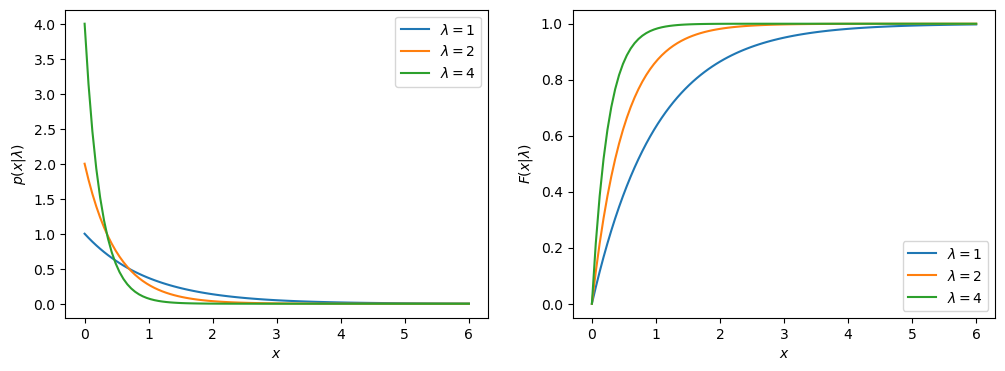

In [3]:
# plot the p.d.f.s and c.d.f.s for a few different values of lambda
# to check we got it right
x = np.linspace(0,6,100)
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(x, exp_pdf(x,1), label='$\lambda=1$')
ax[0].plot(x, exp_pdf(x,2), label='$\lambda=2$')
ax[0].plot(x, exp_pdf(x,4), label='$\lambda=4$')
ax[0].legend()
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$p(x|\lambda)$')

ax[1].plot(x, exp_cdf(x,1), label='$\lambda=1$')
ax[1].plot(x, exp_cdf(x,2), label='$\lambda=2$')
ax[1].plot(x, exp_cdf(x,4), label='$\lambda=4$')
ax[1].legend()
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$F(x|\lambda)$')

plt.show()


In [4]:
# make a function for producing the plot of the data
def my_data_plot(X, lb=2, bins=10, range=(0,2), ax=None):
    ax = ax or plt.gca()
    # make the histogram
    nh, xe = np.histogram(X,bins=bins,range=range)
    cx = 0.5*(xe[1:]+xe[:-1])
    ax.errorbar(cx,nh,nh**0.5, fmt='ko', capsize=2, label='Histogram')
    # make the scatter
    yoff = ax.get_ylim()[1]/7
    y = np.random.normal(-yoff,yoff/6, size=len(X))
    ax.scatter(X,y,s=4,alpha=0.5, label='Scatter')
    ax.set_yticks([0,10,20,30,40])
    ax.set_yticklabels(['0','10','20','30','40'])
    ax.axhline(0,c='k',lw=1)
    ax.set_xlim(range)
    ax.set_ylabel('N')
    ax.set_xlabel('x')
    # draw the pdf line
    bw = xe[1]-xe[0]
    x = np.linspace(*range,200)
    Y = len(X)*bw*exp_pdf(x,lb)
    ax.plot(x,Y,label='Generating PDF')
    ax.legend()
        

 - Let's generate some data (100 events) according to an exponential decay with $\lambda=2$
     - see the full version of this notebook to see how I code this (leaning on knowledge from previous lectures of p.d.f.s, c.d.f.s and inverse c.d.f.s)

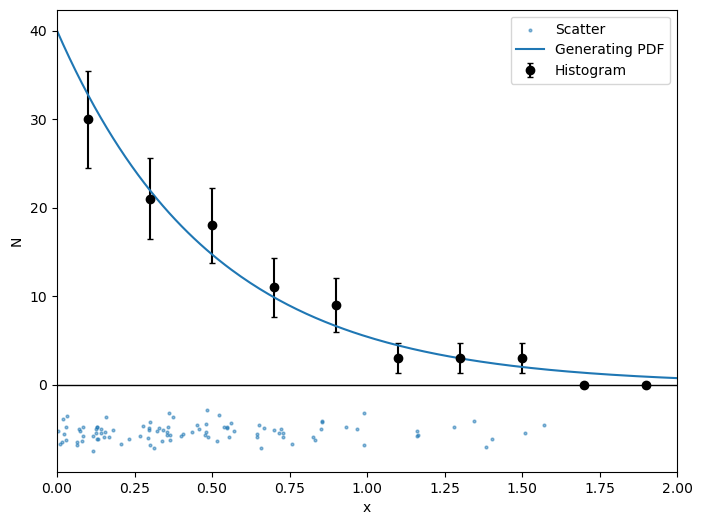

In [6]:
# generate the toy data
lb_true = 2
U = np.random.uniform(size=100)
X = exp_invcdf(U, lb_true)

# plot the toy data
fig, ax = plt.subplots(figsize=(8,6))
my_data_plot(X, lb_true, ax=ax)


### Now we can compute our likelihood

 - This is based on some model *we believe* will be appropriate for our data
 - In this case we will use the exponential distribution (in real life we may or may not know the true distribution)
 - Note, the likelihood **is not the same as the p.d.f** although they are computed in a similar way
 
$$ L(\lambda|X) = \prod_{i}^N p(X_i|\lambda) $$

 - The likelihood depends on the dataset we have and is a function of the parameter we want to estimate

In [7]:
# define the likelihood
def likelihood(lb, x):
    if np.isscalar(lb):
        return np.prod( exp_pdf(x, lb) )
    else:
        return np.array( [ np.prod( exp_pdf(x, l) ) for l in lb ] )


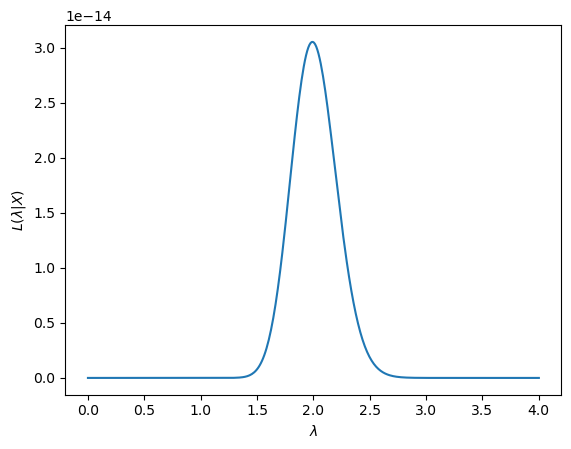

In [8]:
# plot the likelihood
fig, ax = plt.subplots()
lb = np.linspace(0,4,400)
ax.plot(lb, likelihood(lb,X))
ax.set_xlabel('$\lambda$')
ax.set_ylabel('$L(\lambda|X)$')
plt.show()

### Now we can investigate various choices of priors
 - Start with a uniform prior (we have no knowledge) - give a wide range $0 \leq \lambda \leq 4$
 - Use a wide (non-informative) prior, $p(\lambda) = \text{Norm}(1,2)$
 - Use an informative prior, perhaps based on a previous measurement, $p(\lambda) = \text{Norm}(1.2,0.4)$
 - Use a very informative prior, with a narrow width, $p(\lambda) = \text{Norm}(2.2,0.1)$

In [9]:
# define the uniform pdf
def unif_pdf(x, a=0, b=1):
    return np.full_like(x,1/(b-a))

# define the normal pdf
def norm_pdf(x, mu, sg):
    N = (2*np.pi)**-0.5 / sg
    return N * np.exp( -0.5*((x-mu)/sg)**2 )

# check normalisations
assert( np.abs( quad(unif_pdf, 2, 10, args=(2,10))[0] - 1 ) < 1e-8 )
assert( np.abs( quad(norm_pdf, -np.inf, np.inf, args=(1.2, 0.4) )[0] - 1 ) < 1e-8 )
    

In [10]:
# make a list of priors to try
priors = [ 
    lambda x: unif_pdf(x,0,5), 
    lambda x: norm_pdf(x,1,2),
    lambda x: norm_pdf(x,1.2,0.4),
    lambda x: norm_pdf(x,2.2,0.1)
]

titles = [
    'Flat Prior',
    r'$\rm{Norm}(1,2)$ Prior',
    r'$\rm{Norm}(1.2,0.4)$ Prior',
    r'$\rm{Norm}(2.2,0.1)$ Prior'
]


prange = (0,4)

lb = np.linspace(*prange,500)



In [11]:
def draw_prior_likelihood_posterior(prior, likelihood, X, npoints=400, prange=(0,4), ax=None, title=None):
    ax = ax or plt.gca()
    
    # xvals
    x = np.linspace(*prange,npoints)
    
    # prior
    N = quad(prior,*prange)[0]
    y_pr = prior(x) / N
    
    # likelihood
    _L = lambda lb: likelihood(lb,X)
    N = quad(_L,*prange)[0]
    y_L = _L(x) / N
    
    # posterior
    _pst = lambda lb: likelihood(lb,X)*prior(lb)
    N = quad(_pst,*prange)[0]
    y_pst = _pst(x) / N
    
    ax.plot(x, y_L, ls='-', c='r', label='Likelihood')
    ax.plot(x, y_pr, ls=':', c='b', label='Prior')
    ax.plot(x, y_pst, ls='--', c='k', lw=2, label='Posterior')
    ax.legend()
    
    if title:
        ax.set_title(title)
    

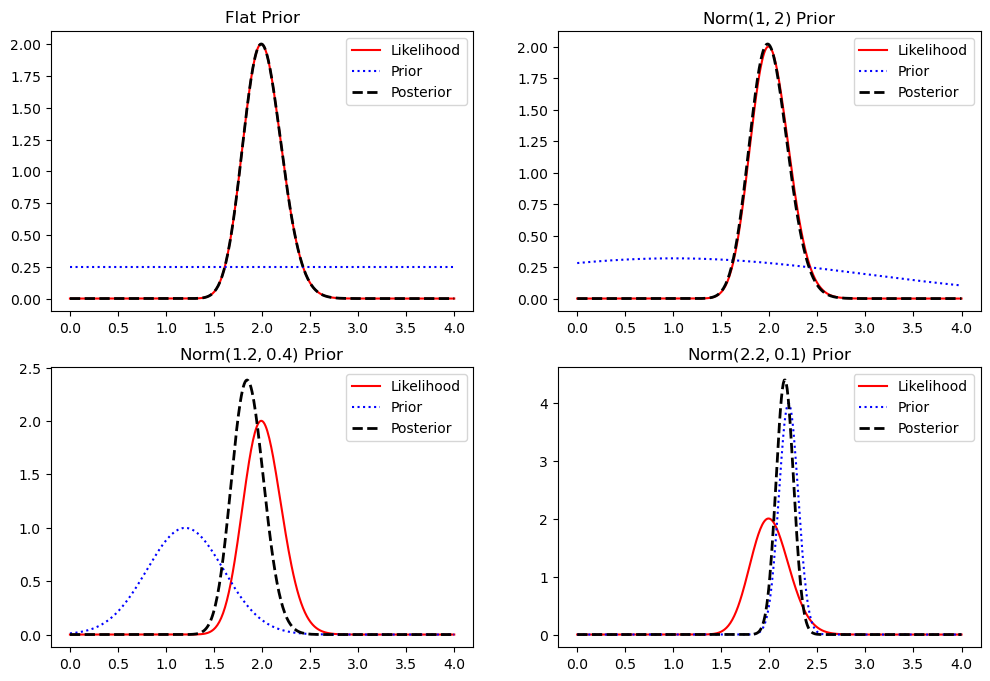

In [12]:
# draw outcome for different priors
fig, axes = plt.subplots(2,2,figsize=(12,8))
for prior, title, ax in zip(priors, titles, axes.flatten()[:len(priors)]):
    draw_prior_likelihood_posterior(prior,likelihood,X,ax=ax,title=title)

### Notes on pdfs

 - In the above (in order to demonstrate) I wrote out the functional form of the probability distributions we needed
 - In practise these are usually already definied in some useful packages
 - For example [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) (well established but a bit slow) and [`numba-stats`](https://pypi.org/project/numba-stats/) (in development but vectorised)

In [13]:
from scipy.stats import norm, expon, uniform
from numba_stats import norm, expon, uniform

### Point-estimates and intervals from the posterior

 - Now we have determined the posterior distribution we can determine an inferred value and uncertainty from this
 - The value (or point estimate) can be the mode, median, mean or something else of the posterior.
   - Often depends on the actual posterior distribution
   - Normally use the maximum a posteriori probablity (MAP) estimate, i.e. the mode
   - For a Gaussian these are all the same
 - The credible interval is often the Highest Density Interval (HDI) but could be the Equal-Tailed Interval (ETI), RMS, variance or something else
   - It is common to use the HDI
 - In this case I write the code from scratch myself to demonstrate how it's done 
 - But for real use case I suggest taking advantage of algorithms from the excellent [`arviz`](https://arviz-devs.github.io/arviz/index.html) package

In [14]:
# use the posterior with the wide prior
_posterior = lambda lb: likelihood(lb,X) * priors[1](lb)

# normalise it over our range to provide the p.d.f
N = quad(_posterior, *prange)[0]
posterior = lambda lb: _posterior(lb) / N

# get the mode
from scipy.optimize import minimize, fmin
_fcn = lambda x: -posterior(x)
mode = fmin(_fcn,2,disp=False)[0]

# we can then numerically compute the c.d.f of the posterior
def posterior_cdf(lb):
    if np.isscalar(lb):
        return quad(posterior,0,lb)[0]
    else:
        return np.array( [quad(posterior,0,l)[0] for l in lb] )

# and use it to numerically create the p.p.f of the posterior
lb = np.linspace(*prange,500)
cdf = posterior_cdf(lb)
lb = lb[(cdf>0) & (cdf<1)]
cdf = cdf[(cdf>0) & (cdf<1)]

from scipy.interpolate import interp1d
posterior_ppf = interp1d(cdf,lb,kind='linear',bounds_error=False,fill_value=tuple(prange))

# define a function which finds the upper value of the interval given the lower value
def width(low, ci):
    return posterior_ppf(low+ci) - posterior_ppf(low)

def hdi(ci):
    start = (1-ci)/2
    xlow = fmin(width, start, args=(ci,), disp=False)[0]
    return (posterior_ppf(xlow), posterior_ppf(xlow+ci))



In [16]:
# get the chisq function to convert std devs into intervals
from scipy.stats import chi2
def my_posterior_plot(posterior, prange=(1,3), npoints=500, ax=None, sigmas=[1,2,3], cols=['lightcoral','indianred','darkred']):
    
    ax = ax or plt.gca()
    
    x = np.linspace(*prange,npoints)
    
    for sigma, col in zip(reversed(sigmas),cols):
        ci = chi2.cdf(sigma**2,1)
        interval = hdi(ci)
        xint = np.linspace(*interval,200)
        yint = posterior(xint)
        ax.fill_between(xint,0,yint,color=col,label=f'${ci:.1%}$% HDI')
        if sigma==1:
            err = (interval[1]-interval[0])/2
    
    ax.plot([mode,mode], [0,posterior(mode)], 'k--', label='MAP')
    ax.plot(x,posterior(x), lw=2, label='Posterior')
    ax.legend()
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$p(\theta|x)$')
    ax.text(0.05,0.9, f'$\\theta = {mode:3.1f} \pm {err:3.1f}$', fontsize=14, transform=ax.transAxes)
    ax.set_ylim(bottom=0)
        


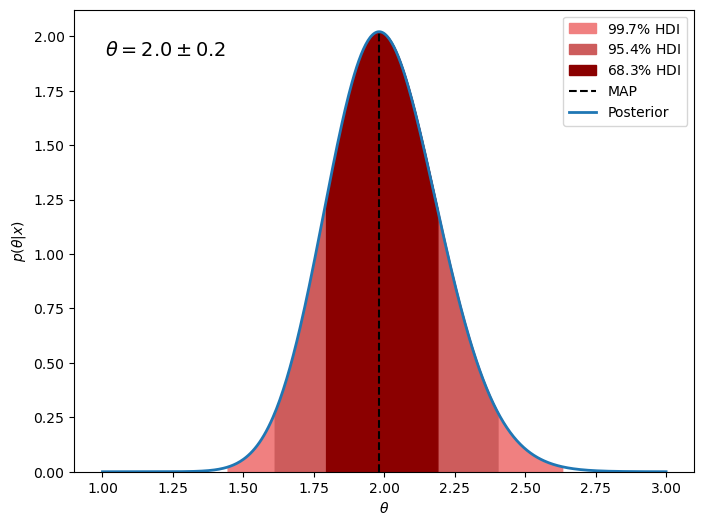

In [17]:
# plot the posterior
fig, ax = plt.subplots(figsize=(8,6))
my_posterior_plot(posterior, ax=ax)

### Let's compare to the MLE we saw in the last lecture

- How does the Bayesian inference with a flat prior compare to the MLE?
- Of course in this case they are same because the posterior with a flat prior is the likelihood
- Thus the maximum likelihood estimate (MLE) is the maximum a posteriori probability estimate (MAP)
- If these are Gaussian distributions then where we evaluate the confidence / credible interval will also be the same


In [24]:
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL

c = UnbinnedNLL(X, exp_pdf)
m = Minuit(c, lb=1.4)
m.migrad()
m.hesse()
#print(m.params)

def find_crossing( x, y, cross, xmin ):
    
    lower = interp1d( y[x<xmin], x[x<xmin], kind='quadratic' )
    upper = interp1d( y[x>xmin], x[x>xmin], kind='quadratic' )

    return lower(cross), upper(cross)

def my_deltalnL_plot(mi, prange=(1,3), npoints=500, ax=None, sigmas=[1,2,3],cols=['lightcoral','indianred','darkred']):
    ax = ax or plt.gca()
    
    x = np.linspace(*prange, npoints)
    nll = []
    for p in x:
        mi.values['lb'] = p
        mi.fixed['lb'] = True
        mi.migrad()
        nll.append(mi.fval)
    
    nll = np.array(nll)
    mi.fixed['lb'] = False
    mi.migrad()
    xmin = mi.values['lb']
    fmin = mi.fval
    
    nll = np.concatenate( [nll[x<xmin], [fmin], nll[x>xmin]] )
    x   = np.concatenate( [x[x<xmin], [xmin], x[x>xmin]] )    
    
    nll -= fmin
    
    smooth = interp1d(x, nll)
    
    for sigma, col in zip(reversed(sigmas), cols):
        ci = chi2.cdf(sigma**2,1)
        low, up = find_crossing(x, nll, sigma**2, xmin)
        #print(low,up)
        xint = np.linspace(low,up,200)
        ax.fill_between(xint,0,smooth(xint), color=col, label=f'${ci:.1%}$% CL')
        if sigma==1:
            err = (up-low)/2
    
    ax.plot(x,nll,lw=2,label='Likelihood')
    ax.legend(loc='upper right')
    ax.set_ylim(bottom=0)
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$-2\Delta\ln L(\theta|X)$')
    ax.text(0.4,0.9, f'$\\theta = {xmin:3.1f} \pm {err:3.1f}$', fontsize=14, transform=ax.transAxes)  
    

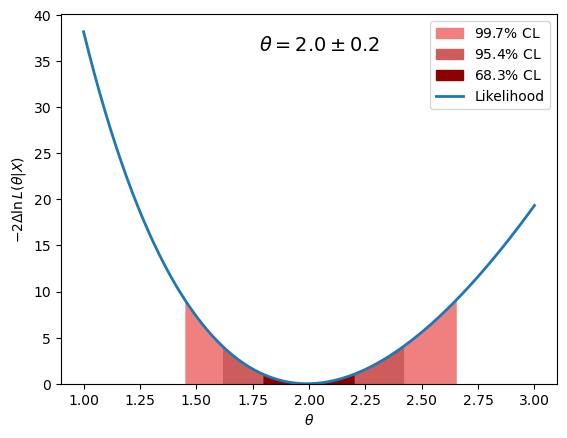

In [25]:
fig, ax = plt.subplots()
my_deltalnL_plot(m, ax=ax)